In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 15
# plt.rcParams['legend.fontsize'] = 12

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

## Input Separation

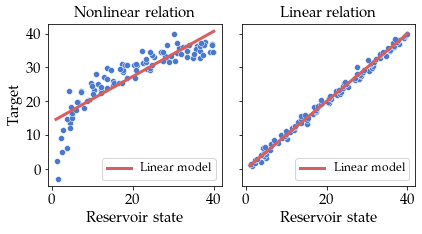

In [7]:
from sklearn.linear_model import LinearRegression

y_func = lambda x : np.exp(x)

x_input = np.linspace(1, 40, 100)
y_input = np.log(x_input)

np.random.seed(42)
x = x_input + np.random.normal(0, 1, x_input.shape)
y_nonlin = y_input + np.random.normal(0, 0.2, y_input.shape)
y_linear = y_func(y_input)
y_nonlin = y_nonlin / y_nonlin.max() * y_linear.max()

model_nonlin = LinearRegression()
model_nonlin.fit(x_input.reshape(-1, 1), y_nonlin)
y_hat_nonlin = model_nonlin.predict(x_input.reshape(-1, 1))

model_linear = LinearRegression()
model_linear.fit(x_input.reshape(-1, 1), y_linear)
y_hat_linear = model_linear.predict(x_input.reshape(-1, 1))

# y_linear_input = np.exp(y_input)

with plt.style.context('seaborn-muted'):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7 / 4 * 3.5, 3.5), constrained_layout=False, sharey=True, sharex=True)

  colors = sns.color_palette()

  sns.scatterplot(x=x, y=y_nonlin, ax=ax1, color=colors[0])
  sns.lineplot(x=x_input, y=y_hat_nonlin, ax=ax1, color=colors[2], linewidth=3, label='Linear model')

  sns.scatterplot(x=x, y=y_linear, ax=ax2, color=colors[0])
  sns.lineplot(x=x_input, y=y_hat_linear, ax=ax2, color=colors[2], linewidth=3, label='Linear model')

  for ax in (ax1, ax2):
    ax.set_xlabel('Reservoir state')
    ax.set_ylabel('Target')
    ax.legend(loc='lower right')
  ax1.set_title('Nonlinear relation', fontsize=15)
  ax2.set_title('Linear relation', fontsize=15)
  plt.tight_layout()
  plt.savefig('explainer_input_sep.png', dpi=200, facecolor='white')
  plt.show()

## Fading Memory

In [3]:
class EchoStateNetwork:

  def __init__(self, *, in_size, res_size, leak_rate, random_seed=42, X_init=None, radius=1.25):
    self.in_size = in_size
    self.res_size = res_size
    self.leak_rate = leak_rate
    self.seed = random_seed
    self.bias_in = None
    self.W_in = None
    self.W_res = None
    self.X_init = X_init
    self.radius = radius
    self._init_reservoir()

  def _init_reservoir(self):
    # partially based on https://mantas.info/wp/wp-content/uploads/simple_esn/minimalESN.py
    np.random.seed(self.seed)
    self.W_in = np.random.rand(self.res_size, self.in_size) - 0.5
    self.bias_in = np.random.rand() - 0.5
    self.W_res = np.random.rand(self.res_size, self.res_size) - 0.5 

    # normalizing and setting spectral radius (correct, slow):
    print('Computing spectral radius...')
    rhoW = max(abs(np.linalg.eig(self.W_res)[0]))
    print('done.')
    self.W_res *= self.radius / rhoW

    # Generating the initial reservoir
    if self.X_init is None:
      self.X_init = np.zeros(self.res_size)
    else:
      assert len(X_init) == self.res_size

  
  def feed_input(self, u):
    assert len(u.shape) == 2
    assert u.shape[1] == self.in_size

    X_hist = np.empty((len(u) + 1, *self.X_init.shape))
    X_hist[0] = self.X_init

    for i in range(len(u)):
      X_step = self.bias_in + self.W_in @ u[i] + self.W_res @ X_hist[i]
      X_step = np.tanh(X_step)
      X_step = (1 - self.leak_rate) * X_hist[i] + self.leak_rate * X_step
      X_hist[i+1] = X_step

    return X_hist


model = EchoStateNetwork(in_size=1, res_size=100, leak_rate=0.3)

Computing spectral radius...
done.


In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler


X, y = fetch_california_housing(return_X_y=True, as_frame=True)

scaler = StandardScaler()
for col in X.columns:
  X[[col]] = scaler.fit_transform(X[[col]])

in_series = X.to_numpy()[:1000]


Computing spectral radius...
done.


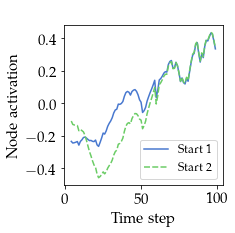

In [5]:
RES_SIZE = 100
INPUT_LEN = 250
LEAK_RATE = 0.16
VIZ_NEURON = 60

# setup
in_series = X.to_numpy()[:INPUT_LEN]
model = EchoStateNetwork(in_size=in_series.shape[1], res_size=RES_SIZE, leak_rate=LEAK_RATE, random_seed=42, radius=1.25)
X_init_0 = (np.random.rand((RES_SIZE)) * 2) - 1
X_init_1 = (np.random.rand((RES_SIZE)) * 2) - 1
reservoirs = [X_init_0, X_init_1]


# execution
X_hists = []
for X_init in reservoirs:
  model.X_init = X_init
  X_hist = model.feed_input(in_series)
  X_hists.append(X_hist)


# np.random.seed(42)
# for VIZ_NEURON in np.random.randint(0, 100, 10):

X_hist0, X_hist1 = X_hists
X_traj0 = X_hist0[:, VIZ_NEURON]
X_traj1 = X_hist1[:, VIZ_NEURON]
X_traj = np.column_stack((X_traj0, X_traj1))
traj_df = pd.DataFrame(X_traj, columns=('Start 1', 'Start 2'))


with plt.style.context('seaborn-muted'):
  fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), constrained_layout=False)
  sns.lineplot(data=traj_df.iloc[4:100], ax=ax)
  ax.set_xlabel('Time step')
  ax.set_ylabel('Node activation')
  ax.legend(loc='lower right')
  ax.set_title(' ')
  plt.tight_layout()
  plt.savefig('explainer_fading_mem.png', dpi=200, facecolor='white')
  plt.show()


Computing spectral radius...
done.


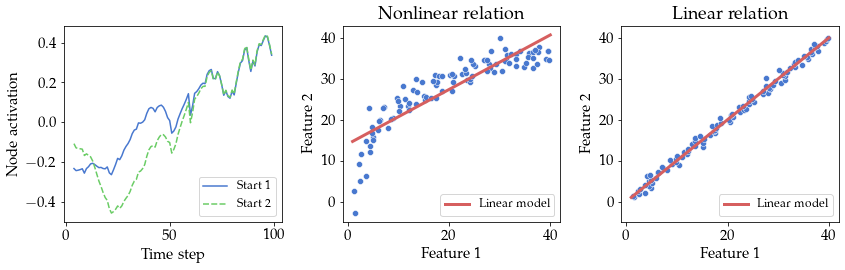

In [6]:
RES_SIZE = 100
INPUT_LEN = 250
LEAK_RATE = 0.16
VIZ_NEURON = 60

# setup
in_series = X.to_numpy()[:INPUT_LEN]
model = EchoStateNetwork(in_size=in_series.shape[1], res_size=RES_SIZE, leak_rate=LEAK_RATE, random_seed=42)
X_init_0 = (np.random.rand((RES_SIZE)) * 2) - 1
X_init_1 = (np.random.rand((RES_SIZE)) * 2) - 1
reservoirs = [X_init_0, X_init_1]


# execution
X_hists = []
for X_init in reservoirs:
  model.X_init = X_init
  X_hist = model.feed_input(in_series)
  X_hists.append(X_hist)


X_hist0, X_hist1 = X_hists
X_traj0 = X_hist0[:, VIZ_NEURON]
X_traj1 = X_hist1[:, VIZ_NEURON]
X_traj = np.column_stack((X_traj0, X_traj1))
traj_df = pd.DataFrame(X_traj, columns=('Start 1', 'Start 2'))


with plt.style.context('seaborn-muted'):
  # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=False)
  fig = plt.figure(figsize=(12, 4), constrained_layout=False)
  
  ax1 = plt.subplot(131)
  sns.lineplot(data=traj_df.iloc[4:100], ax=ax1)
  ax1.set_xlabel('Time step')
  ax1.set_ylabel('Node activation')
  ax1.legend(loc='lower right')

  colors = sns.color_palette()
  ax2 = plt.subplot(132)
  sns.scatterplot(x=x, y=y_nonlin, ax=ax2, color=colors[0])
  sns.lineplot(x=x_input, y=y_hat_nonlin, ax=ax2, color=colors[2], linewidth=3, label='Linear model')
  ax3 = plt.subplot(133, sharey=ax2)
  sns.scatterplot(x=x, y=y_linear, ax=ax3, color=colors[0])
  sns.lineplot(x=x_input, y=y_hat_linear, ax=ax3, color=colors[2], linewidth=3, label='Linear model')

  for ax in (ax2, ax3):
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(loc='lower right')
  ax2.set_title('Nonlinear relation')
  ax3.set_title('Linear relation')

  plt.tight_layout()
  # plt.savefig('explainer_fading_mem.png', dpi=200, facecolor='white')
  plt.show()
